# Exercises Chapters 13 & 14

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

## Air Pollution
In the previous chapter, as an exercise, we prepared the air pollution dataset for deep
learning modeling. Now we’ll use the training set, validation set, and test set to build
baseline models and evaluate them.

For each type of model, follow the steps outlined. Recall that the target for the singlestep and multi-step model is the concentration of NO2, and the targets for the multioutput model are the concentration of NO2 and temperature. 

1. For the single-step model

    a. Build a baseline model that predicts the last known value.
   
    b. Plot it.
   
    c .Evaluate its performance using the mean absolute error (MAE) and store it for comparison in a dictionary.
   
3. For the multi-step model
   
    a. Build a baseline that predicts the last known value over a horizon of 24 hours.
   
    b. Build a baseline model that repeats the last 24 hours.
   
    c. Plot the predictions of both models.
   
    d. Evaluate both models using the MAE and store their performance.
   
5. For the multi-output model
   
    a. Build a baseline model that predicts the last known value.
   
    b. Plot it.
   
    c. Evaluate its performance using the MAE and store it for comparison in a dictionary.

In [7]:
train_df = pd.read_csv('data/ex_train.csv')
val_df = pd.read_csv('data/ex_val.csv')
test_df = pd.read_csv('data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### 1. For the single-step model

#### 1.a Build a baseline model that predicts the last known value

In [12]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2']) 

wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [13]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [14]:
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [15]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

119/119 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0287


#### 1.b Plot it

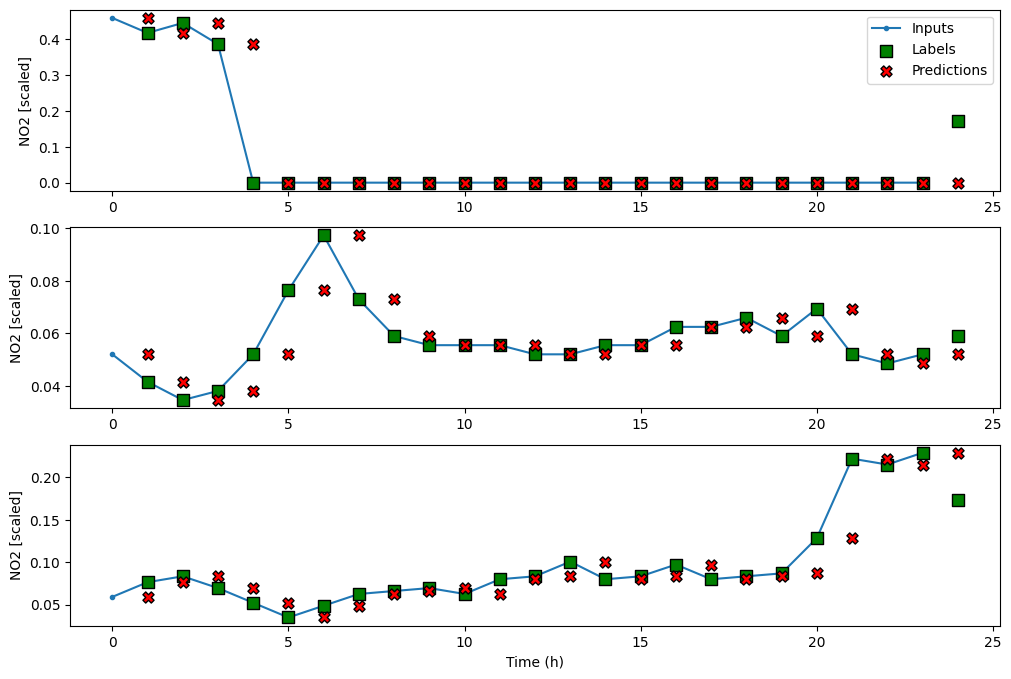

In [17]:
wide_window.plot(baseline_last)

#### 1.c Evaluate its performance using the mean absolute error (MAE) and store it for comparison in a dictionary.

In [19]:
# MAE of Validation and Test sets
mae_val = val_performance['Baseline - Last'][1]
mae_test = performance['Baseline - Last'][1]

print(f'MAE of validation set: {mae_val:.4}')
print(f'      MAE of Test set: {mae_test:.4}')

MAE of validation set: 0.02873
      MAE of Test set: 0.03336


### 2. For the multi-step model

#### 2.a Build a baseline that predicts the last known value over a horizon of 24 hours.

In [22]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [23]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [24]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 1s 2ms/step - loss: 0.1443 - mean_absolute_error: 0.2821


#### 2.b Build a baseline model that repeats the last 24 hours.

In [26]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [27]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 0s 2ms/step - loss: 0.1426 - mean_absolute_error: 0.2818


#### 2.c Plot the predictions of both models.

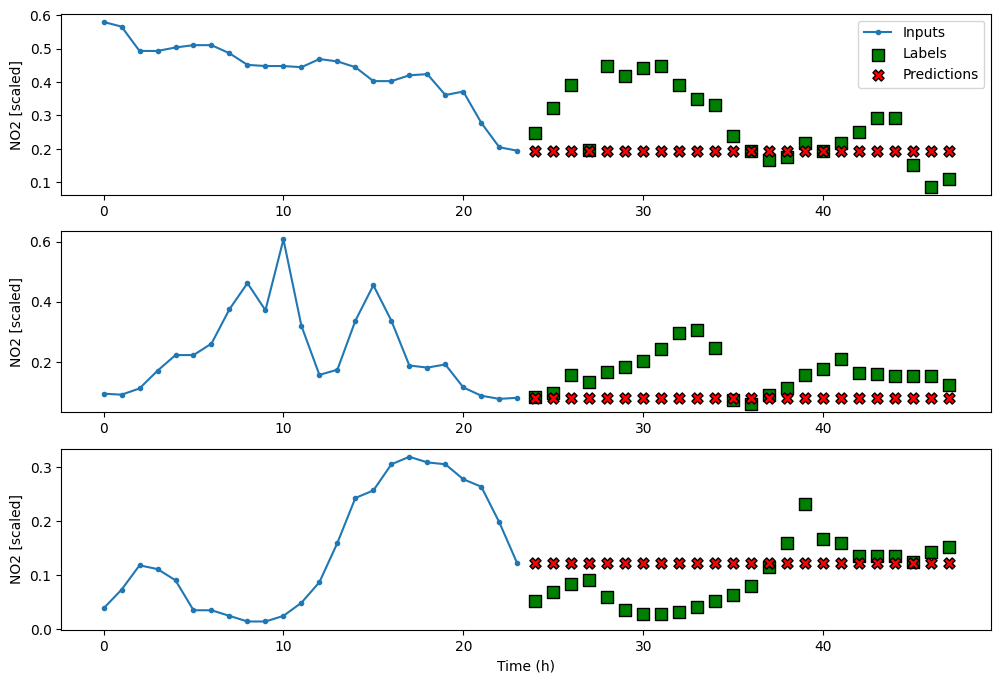

In [29]:
# Plot Baseline Last Known Value 
multi_window.plot(ms_baseline_last)

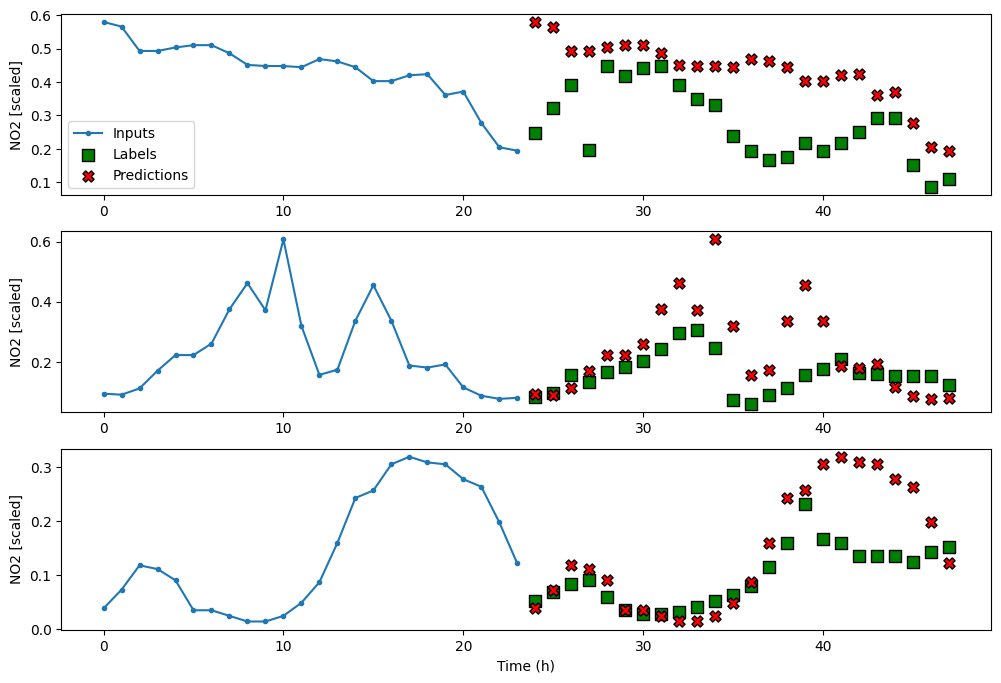

In [30]:
# Plot Baseline Repeat the last 24 hours
multi_window.plot(ms_baseline_repeat)

#### 2.d Evaluate both models using the MAE and store their performance.

In [32]:
# MAE of Validation and Test sets
mae_vall = ms_val_performance['Baseline - Last'][1]
mae_testl = ms_performance['Baseline - Last'][1]

print(f'MAE of validation set: {mae_vall:.4}')
print(f'      MAE of Test set: {mae_testl:.4}')

MAE of validation set: 0.2821
      MAE of Test set: 0.2429


In [33]:
# MAE of Validation and Test sets
mae_valr = ms_val_performance['Baseline - Repeat'][1]
mae_testr = ms_performance['Baseline - Repeat'][1]

print(f'MAE of validation set: {mae_valr:.4}')
print(f'      MAE of Test set: {mae_testr:.4}')

MAE of validation set: 0.2818
      MAE of Test set: 0.2441


### 3. For the multi-output model

#### 3.a Build a baseline model that predicts the last known value.

In [36]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])

In [37]:
print(column_indices['NO2'])
print(column_indices['TEMP'])

3
6


In [38]:
mo_baseline_last = Baseline(label_index=[3, 6])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

118/118 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0215


#### 3.b Plot it.

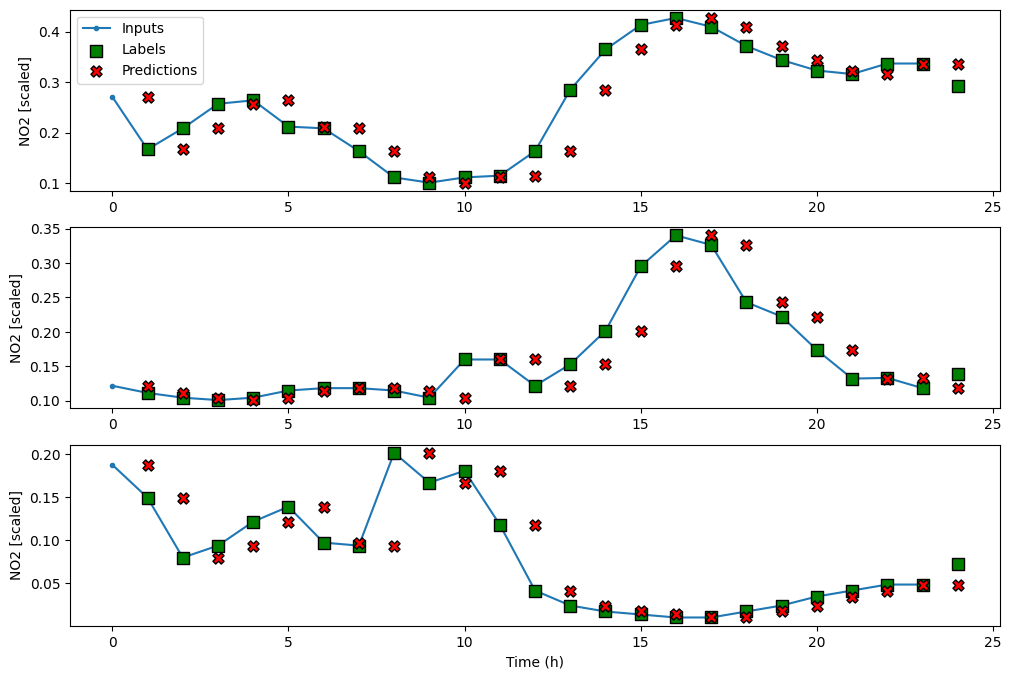

In [40]:
mo_wide_window.plot(mo_baseline_last)

#### 3.c Evaluate its performance using the MAE and store it for comparison in a dictionary.

In [42]:
# MAE of Validation and Test sets
mae_valo = mo_val_performance['Baseline - Last'][1]
mae_testo = mo_performance['Baseline - Last'][1]

print(f'MAE of validation set: {mae_valo:.4}')
print(f'      MAE of Test set: {mae_testo:.4}')

MAE of validation set: 0.02148
      MAE of Test set: 0.02479


# Exercises Chapter 14

#### Now you’ll build linear models and deep neural networks. 

1 For the single-step model:

    a. Build a linear model.
    b. Plot its predictions.
    c. Measure its performance using the mean absolute error (MAE) and store it.
    d. Build a deep neural network (DNN).
    e. Plot its predictions.
    f. Measure its performance using the MAE and store it.
    g. Which model performs best?

2 For the multi-step model:

    a. Build a linear model.
    b. Plot its predictions.
    c. Measure its performance using the MAE and store it.
    d. Build a DNN.
    e. Plot its predictions.
    f. Measure its performance using the MAE and store it.
    g. Which model performs best?

3 For the multi-output model:

    a. Build a linear model.
    b. Plot its predictions.
    c. Measure its performance using the MAE and store it.
    d. Build a DNN.
    e. Plot its predictions.
    f. Measure its performance using the MAE and store it.
    g. Which model performs best?

In [45]:
# Define the function 'compile_and_fit' to compile and train the model
def compile_and_fit(model, window, patience=3, max_epochs=50):  
    
    # Early stopping to stop training if validation loss does not improve after a certain number of epochs
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                                   patience=patience,   # Patience defines how many epochs to wait before stopping
                                   mode='min')          # The mode specifies that the training will stop when the validation loss stops decreasing
    
    # Compile the model by specifying the loss function, optimizer, and metrics to be monitored during training
    model.compile(loss=MeanSquaredError(),              # Loss function is Mean Squared Error (MSE)
                  optimizer=Adam(),                     # Optimizer is Adam, a popular gradient-based optimization algorithm
                  metrics=[MeanAbsoluteError()])        # Metrics to monitor are Mean Absolute Error (MAE)
    
    # Train the model using the training data ('window.train'), and validate it using the validation data ('window.val')
    history = model.fit(window.train,                   # Training data
                       epochs=max_epochs,               # Maximum number of epochs for training
                       validation_data=window.val,      # Validation data
                       callbacks=[early_stopping])      # Use the early stopping callback to monitor training
    
    return history                                      # Return the history object

### Single-step
#### Linear model

In [47]:
# Define a simple linear model with a single dense layer
linear = Sequential([  # Initialize the Sequential model
    Dense(units=1)     # Add a single Dense layer with one unit (output) for linear regression
])

# Compile and train the model using the 'compile_and_fit' function defined earlier
history = compile_and_fit(linear, single_step_window)

# Evaluate the model on the validation dataset and store the result in val_performance dictionary
val_performance['Linear'] = linear.evaluate(single_step_window.val)

# Evaluate the model on the test dataset and store the result in performance dictionary
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0) 

Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.0204 - mean_absolute_error: 0.1132 - val_loss: 0.0108 - val_mean_absolute_error: 0.0830
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0648 - val_loss: 0.0051 - val_mean_absolute_error: 0.0549
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0465 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411
Epoch 4/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0363 - val_loss: 0.0024 - val_mean_absolute_error: 0.0338
Epoch 5/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0312 - val_loss: 0.0021 - val_mean_absolute_error: 0.0306
Epoch 6/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0290 - val_loss: 0.0020 - val_mean_absolute_error: 0.0291
Epoch 7/50
414/4

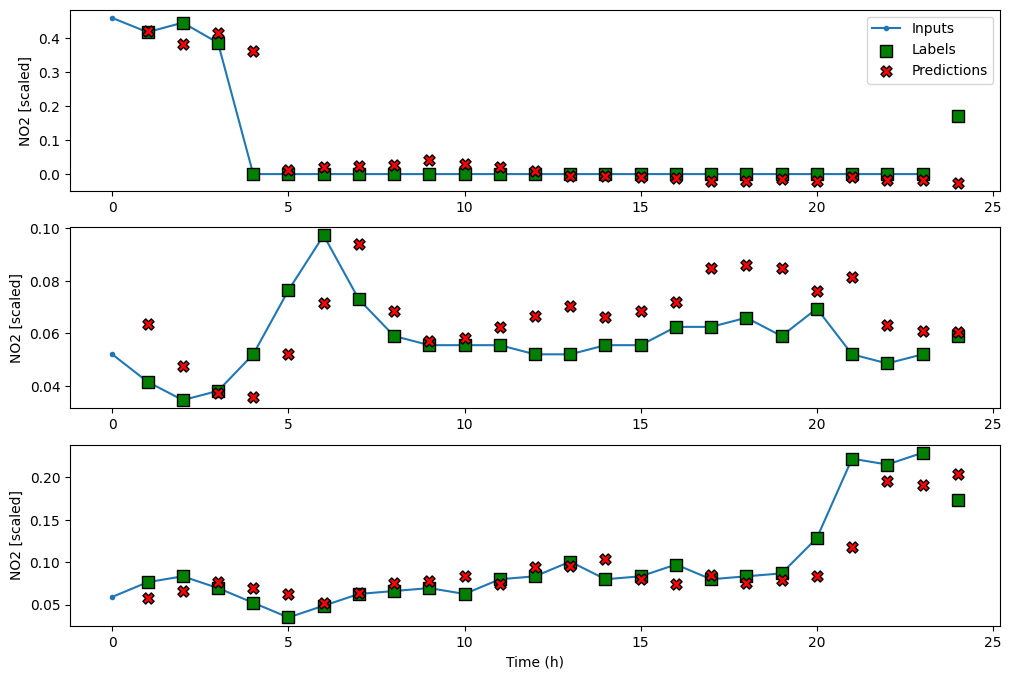

In [48]:
wide_window.plot(linear)

#### Dense Model (DNN)

In [50]:
# Define a neural network model with two hidden layers and one output layer
dense = Sequential([                     # Initialize the Sequential model
    Dense(units=64, activation='relu'),  # Add a Dense layer with 64 units and ReLU activation function
    Dense(units=64, activation='relu'),  # Add another Dense layer with 64 units and ReLU activation function
    Dense(units=1)                       # Add the output layer with 1 unit (for regression, this would be the predicted value)
])

# Compile and train the model using the 'compile_and_fit' function defined earlier
history = compile_and_fit(dense, single_step_window) 

# Evaluate the model on the validation dataset and store the result in the val_performance dictionary
val_performance['Dense'] = dense.evaluate(single_step_window.val) 

# Evaluate the model on the test dataset and store the result in the performance dictionary
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)  

Epoch 1/50
414/414 [==============================] - 3653s 9s/step - loss: 0.0043 - mean_absolute_error: 0.0405 - val_loss: 0.0020 - val_mean_absolute_error: 0.0291
Epoch 2/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0269 - val_loss: 0.0019 - val_mean_absolute_error: 0.0285
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0272 - val_loss: 0.0020 - val_mean_absolute_error: 0.0294
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0267 - val_loss: 0.0019 - val_mean_absolute_error: 0.0283
Epoch 5/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0267 - val_loss: 0.0020 - val_mean_absolute_error: 0.0285
Epoch 6/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0270 - val_loss: 0.0019 - val_mean_absolute_error: 0.0276
Epoch 7/50
414

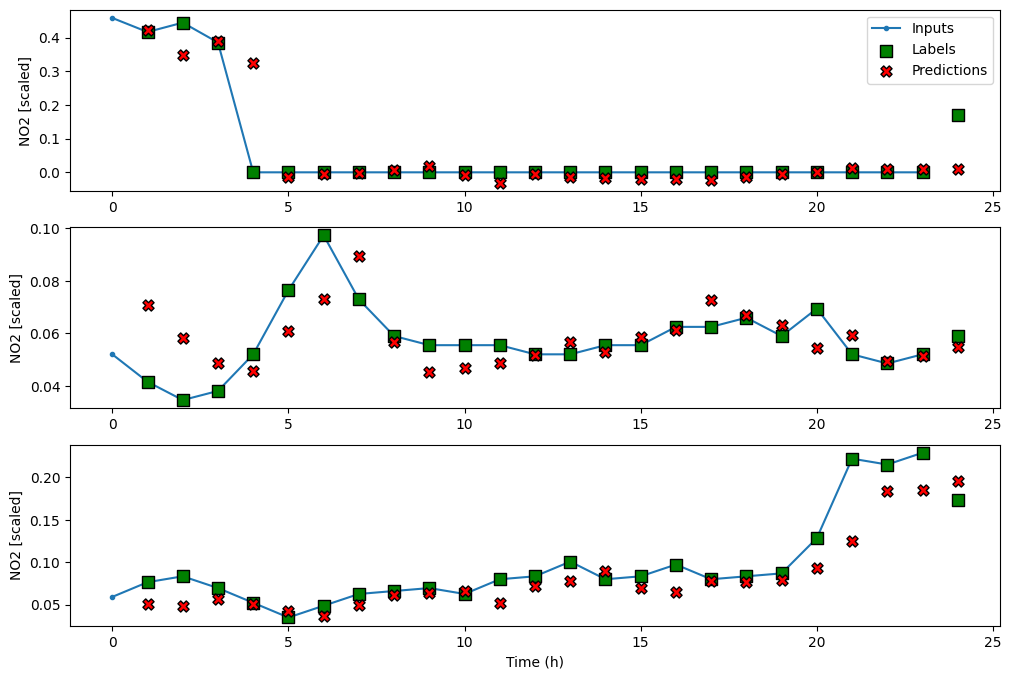

In [51]:
wide_window.plot(dense)

#### Evaluation

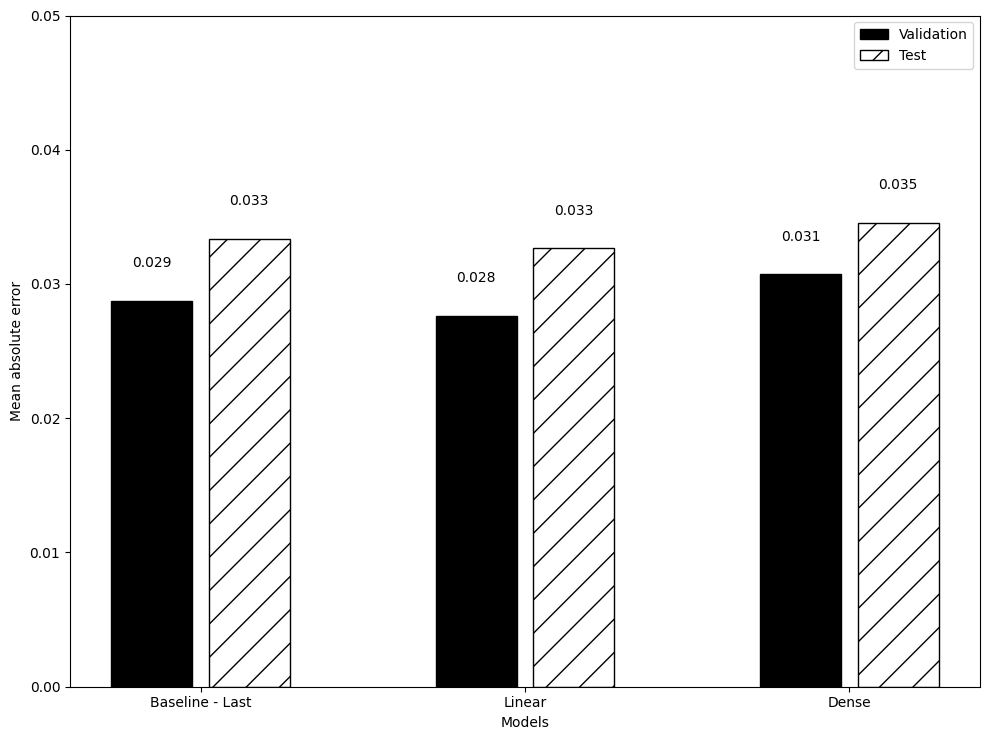

In [53]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.05)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### Multi-step
#### Linear model

In [55]:
# Set the index for the target variable (NO2) from the column indices
label_index = column_indices['NO2']  

# Get the number of features (columns) in the training data
num_features = train_df.shape[1] 

# Define the model architecture for the linear model with one output unit (a single value)
ms_linear = Sequential([                                # Initialize the Sequential model
    Dense(1, kernel_initializer=tf.initializers.zeros)  # Add a Dense layer with one unit and zero-initialized weights
])

# Compile and fit the model using the custom 'compile_and_fit' function, passing the multi-window training data
history = compile_and_fit(ms_linear, multi_window) 

# Evaluate the model on the validation dataset and store the result in the 'ms_val_performance' dictionary
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)  

# Evaluate the model on the test dataset and store the result in the 'ms_performance' dictionary
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0) 

Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.0147 - mean_absolute_error: 0.0930 - val_loss: 0.0095 - val_mean_absolute_error: 0.0736
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0847 - val_loss: 0.0091 - val_mean_absolute_error: 0.0717
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0120 - mean_absolute_error: 0.0835 - val_loss: 0.0089 - val_mean_absolute_error: 0.0709
Epoch 4/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0118 - mean_absolute_error: 0.0827 - val_loss: 0.0088 - val_mean_absolute_error: 0.0703
Epoch 5/50
413/413 [==============================] - 1s 3ms/step - loss: 0.0117 - mean_absolute_error: 0.0822 - val_loss: 0.0087 - val_mean_absolute_error: 0.0706
Epoch 6/50
413/413 [==============================] - 1s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0819 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 7/50
413/4

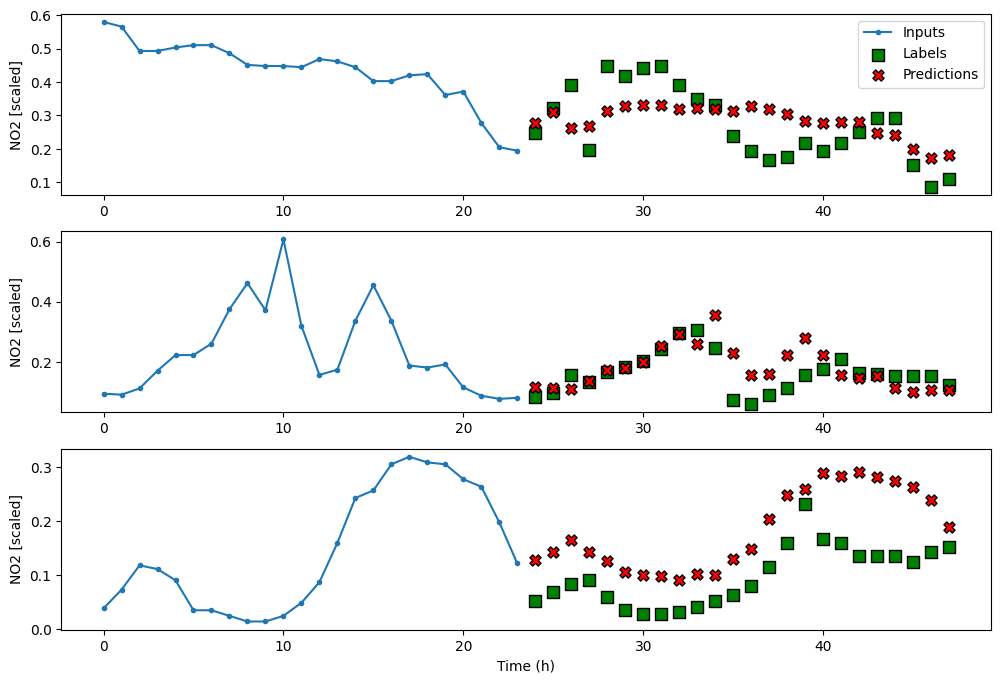

In [56]:
multi_window.plot(ms_linear)

#### Dense model (DNN)

In [58]:
# Define the architecture for the dense model with two hidden layers (64 units each) and one output unit
ms_dense = Sequential([                                  # Initialize the Sequential model
    Dense(64, activation='relu'),                        # Add the first hidden layer with 64 units and ReLU activation
    Dense(64, activation='relu'),                        # Add the second hidden layer with 64 units and ReLU activation
    Dense(1, kernel_initializer=tf.initializers.zeros),  # Add the output layer with 1 unit, initialized to zero
])

# Compile and fit the model using the custom 'compile_and_fit' function, passing the multi-window training data
history = compile_and_fit(ms_dense, multi_window) 

# Evaluate the model on the validation dataset and store the result in the 'ms_val_performance' dictionary
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)

# Evaluate the model on the test dataset and store the result in the 'ms_performance' dictionary
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0) 

Epoch 1/50
413/413 [==============================] - 4s 5ms/step - loss: 0.0127 - mean_absolute_error: 0.0854 - val_loss: 0.0090 - val_mean_absolute_error: 0.0698
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0109 - mean_absolute_error: 0.0793 - val_loss: 0.0085 - val_mean_absolute_error: 0.0686
Epoch 3/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0107 - mean_absolute_error: 0.0784 - val_loss: 0.0086 - val_mean_absolute_error: 0.0696
Epoch 4/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0106 - mean_absolute_error: 0.0777 - val_loss: 0.0097 - val_mean_absolute_error: 0.0727
Epoch 5/50
117/117 [==============================] - 1s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0709


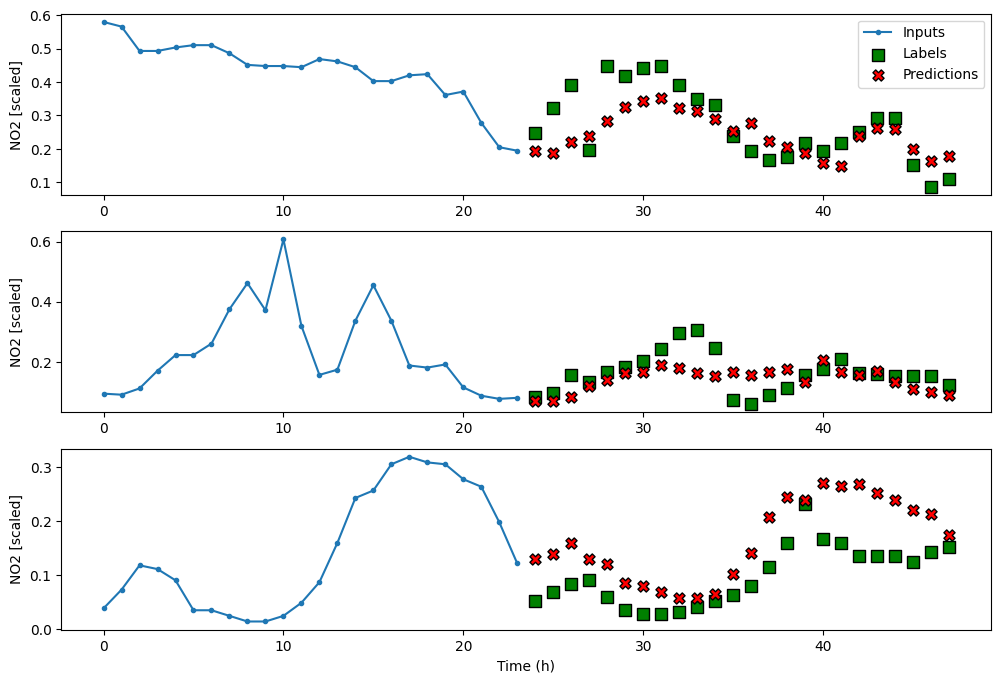

In [59]:
multi_window.plot(ms_dense)

#### Evaluation

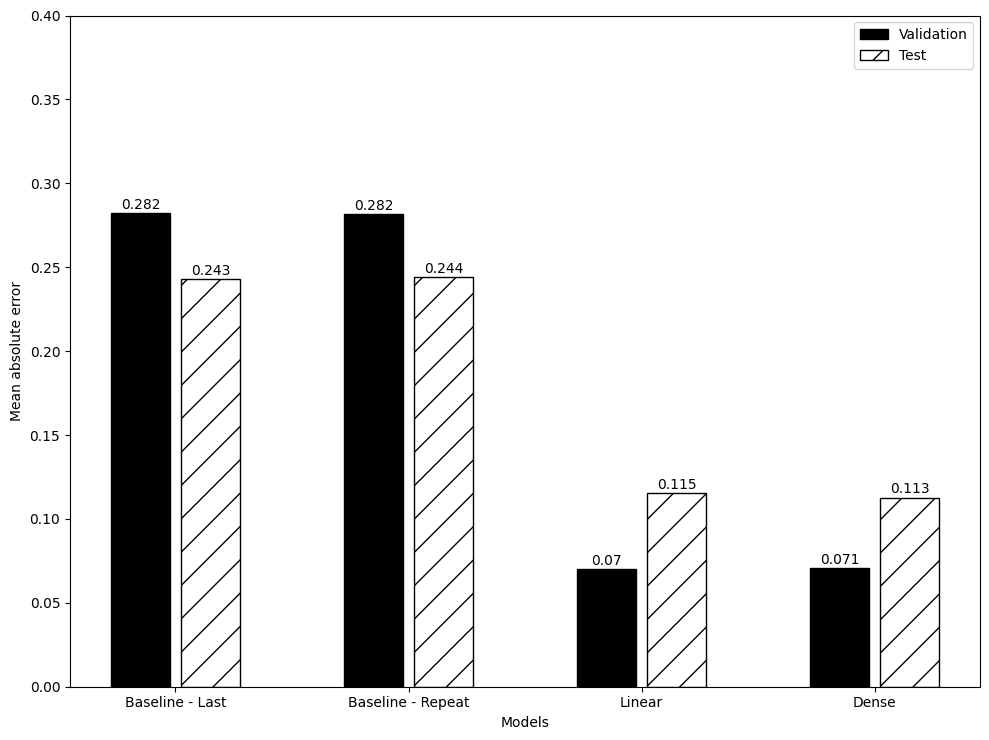

In [61]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### Multi-output
#### Linear model

In [63]:
# Define the architecture for the linear model with a single output unit
mo_linear = Sequential([  # Initialize the Sequential model
    Dense(units=2)        # Add a single dense layer with 2 units (output layer)
])

# Compile and fit the model using the custom 'compile_and_fit' function, passing the multi-step window training data
history = compile_and_fit(mo_linear, mo_single_step_window) 

# Evaluate the model on the validation dataset and store the result in the 'mo_val_performance' dictionary
mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val) 

# Evaluate the model on the test dataset and store the result in the 'mo_performance' dictionary
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0) 

Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.0992 - mean_absolute_error: 0.2343 - val_loss: 0.0235 - val_mean_absolute_error: 0.1271
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0173 - mean_absolute_error: 0.1026 - val_loss: 0.0097 - val_mean_absolute_error: 0.0762
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0695 - val_loss: 0.0050 - val_mean_absolute_error: 0.0528
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0541 - val_loss: 0.0032 - val_mean_absolute_error: 0.0411
Epoch 5/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0461 - val_loss: 0.0024 - val_mean_absolute_error: 0.0350
Epoch 6/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0414 - val_loss: 0.0021 - val_mean_absolute_error: 0.0315
Epoch 7/50
414/4

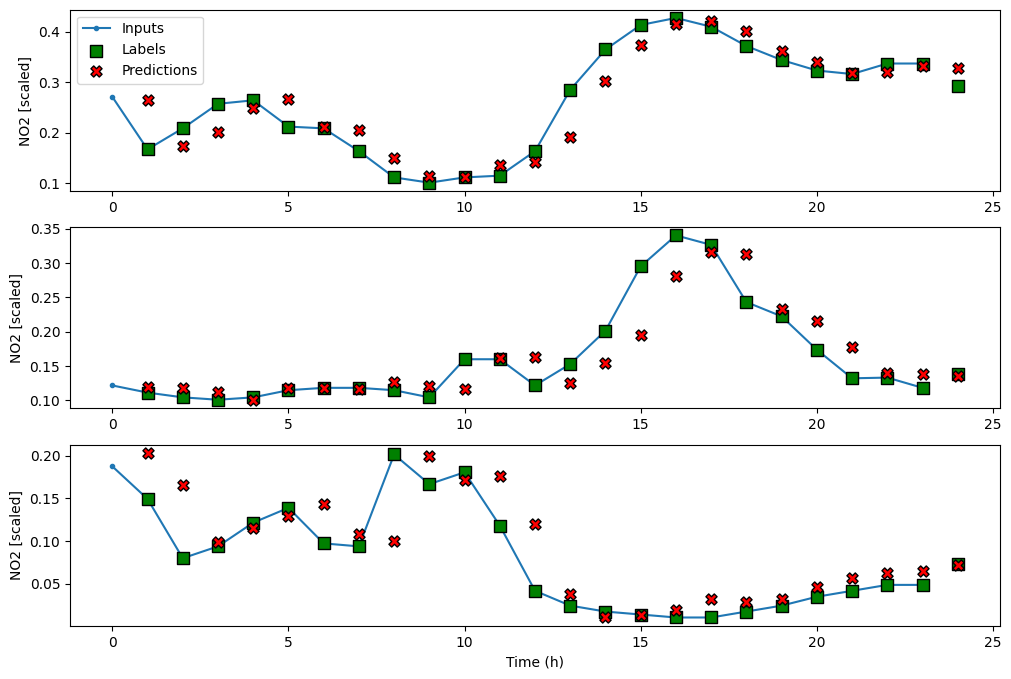

In [64]:
mo_wide_window.plot(mo_linear)

#### Dense model (DNN)

In [66]:
# Define the architecture for the dense model with two hidden layers and an output layer
mo_dense = Sequential([                  # Initialize the Sequential model
    Dense(units=64, activation='relu'),  # Add the first hidden layer with 64 units and ReLU activation function
    Dense(units=64, activation='relu'),  # Add the second hidden layer with 64 units and ReLU activation function
    Dense(units=2)                       # Add the output layer with 2 units (output for multi-step prediction)
])

# Compile and fit the model using the custom 'compile_and_fit' function, passing the multi-step window training data
history = compile_and_fit(mo_dense, mo_single_step_window)  

# Evaluate the model on the validation dataset and store the result in the 'mo_val_performance' dictionary
mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)

# Evaluate the model on the test dataset and store the result in the 'mo_performance' dictionary
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0) 

Epoch 1/50
414/414 [==============================] - 3s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0420 - val_loss: 0.0013 - val_mean_absolute_error: 0.0233
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0217 - val_loss: 0.0013 - val_mean_absolute_error: 0.0232
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 9.9050e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0012 - val_mean_absolute_error: 0.0222
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 9.8794e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0013 - val_mean_absolute_error: 0.0229
Epoch 5/50
414/414 [==============================] - 1s 3ms/step - loss: 9.7989e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0011 - val_mean_absolute_error: 0.0208
Epoch 6/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0206 - val_loss: 0.0013 - val_mean_absolute_error: 0.0229
Epoc

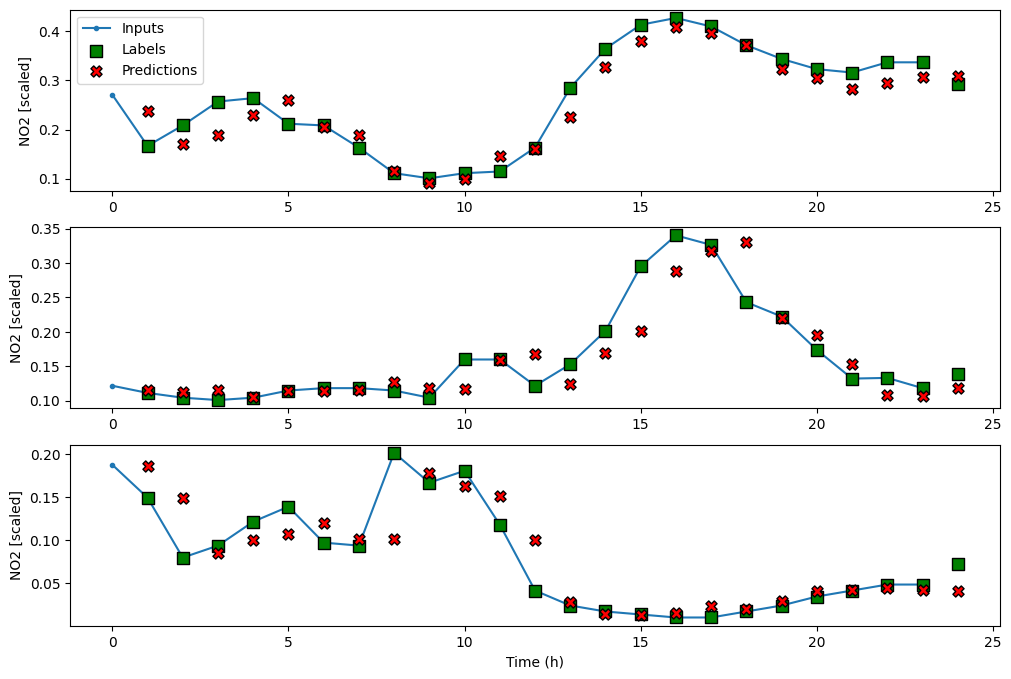

In [67]:
mo_wide_window.plot(mo_dense)

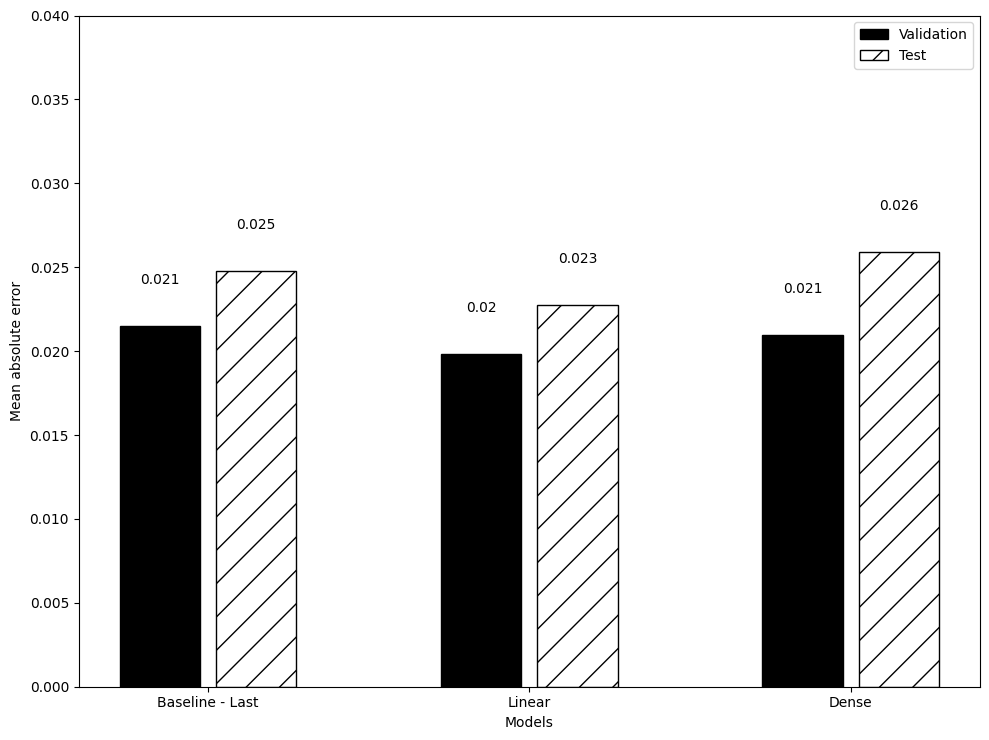

In [68]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.04)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()